Analyzing: Natural Language
Dataset: ../nl_v2.jsonl

✓ Loaded 8256 samples
  Sample keys: ['verbose', 'compressed', 'domain', 'language', 'metadata']

Example sample:
  Verbose (first 100 chars): Artificial intelligence (AI) is revolutionizing quality control in rocket manufacturing by enhancing...
  Compressed (first 100 chars): AI revolutionizing rocket manufacturing QC: +precision | +automated inspections | +failure predictio...

✓ Computed metrics for 8256 samples



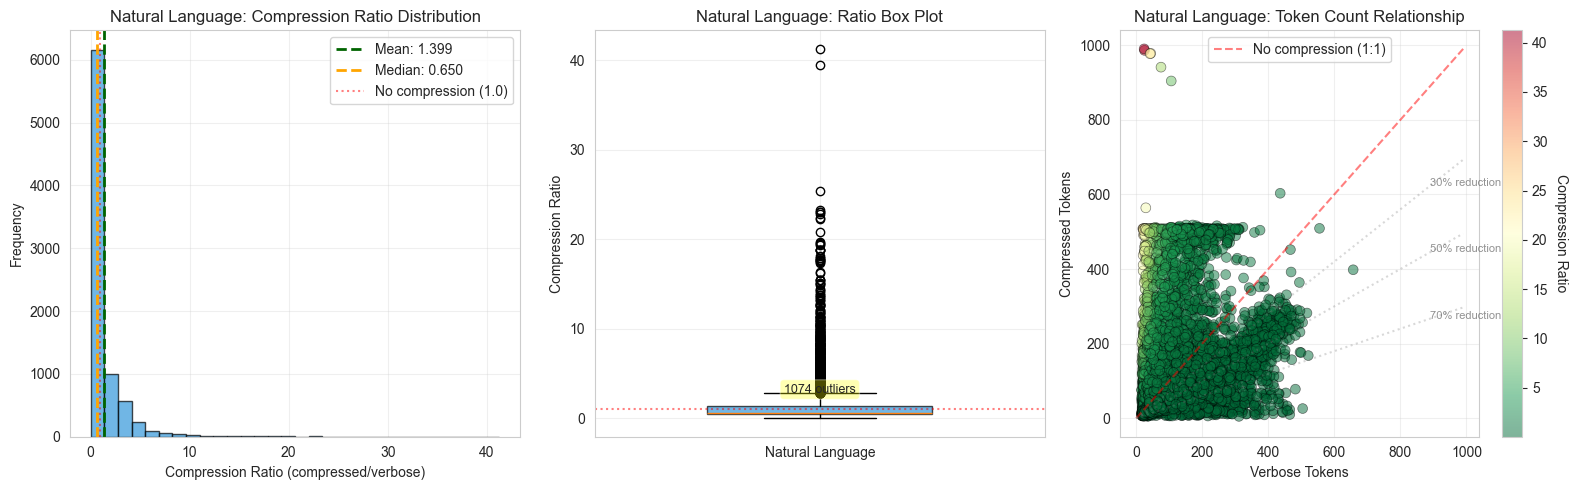


NATURAL LANGUAGE COMPRESSION STATISTICS

Dataset Size: 8256 samples

COMPRESSION RATIO (compressed/verbose):
  Mean:      1.399
  Median:    0.650
  Std Dev:   2.084
  Min:       0.016
  Max:       41.250
  25th %ile: 0.506
  75th %ile: 1.419

TOKEN REDUCTION:
  Mean reduction:   -39.9%
  Median reduction: 35.0%
  Best reduction:   98.4%
  Worst reduction:  -4025.0%

AVERAGE TOKEN COUNTS:
  Verbose:    130 tokens
  Compressed: 130 tokens
  Saved:      0 tokens per sample

TOTAL TOKEN SAVINGS:
  Total verbose tokens:    1,076,104
  Total compressed tokens: 1,072,110
  Total tokens saved:      3,994
  Overall reduction:       0.4%

QUALITY CHECKS

🚨 EXPANSION DETECTED: 2541 samples (30.8%)
   These samples got LONGER after compression (BAD)
   Worst expansion: 41.250 ratio
   → ACTION: Investigate these samples manually

⚠️  WEAK COMPRESSION: 2761 samples (33.4%)
   Ratio > 0.9 means <10% token reduction
   → ACTION: These samples may not be worth compressing

COMPRESSION QUALITY BREAKD

In [ ]:
# Analysis #1: Compression Ratio Distribution
# Single domain analysis (NL)

import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tiktoken

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# ============================================================================
# CONFIGURATION - CHANGE THIS FOR EACH RUN
# ============================================================================

# Choose which dataset to analyze
DATASET_PATH = "../nl_v2.jsonl"  # OR "data/raw/code_dataset.jsonl"
DOMAIN_NAME = "Natural Language"  # OR "Code"
DOMAIN_TYPE = "nl"  # OR "code"

print(f"Analyzing: {DOMAIN_NAME}")
print(f"Dataset: {DATASET_PATH}")
print("=" * 80 + "\n")

# ============================================================================
# 1. LOAD DATA
# ============================================================================


def load_dataset(filepath: str) -> list[dict]:
    """Load dataset with verbose/compressed pairs"""
    data = []
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data


data = load_dataset(DATASET_PATH)

print(f"✓ Loaded {len(data)} samples")
print(f"  Sample keys: {list(data[0].keys())}")

# Show one example
print("\nExample sample:")
print(f"  Verbose (first 100 chars): {data[0]['verbose'][:100]}...")
print(f"  Compressed (first 100 chars): {data[0]['compressed'][:100]}...")

# ============================================================================
# 2. CALCULATE COMPRESSION RATIOS
# ============================================================================


def count_tokens(text: str) -> int:
    """Count tokens using tiktoken (same as your tokenizer.py)"""
    enc = tiktoken.get_encoding("cl100k_base")
    return len(enc.encode(text, disallowed_special=()))


def compute_metrics(sample: dict) -> dict:
    """Compute compression metrics for a sample"""
    verbose = sample["verbose"]
    compressed = sample["compressed"]

    verbose_tokens = count_tokens(verbose)
    compressed_tokens = count_tokens(compressed)

    # Compression ratio (compressed/verbose)
    # Ratio < 1.0 = compression (good)
    # Ratio > 1.0 = expansion (bad)
    ratio = compressed_tokens / verbose_tokens if verbose_tokens > 0 else 1.0

    # Token reduction percentage
    reduction_pct = (1 - ratio) * 100

    # Token savings
    tokens_saved = verbose_tokens - compressed_tokens

    return {
        "verbose_tokens": verbose_tokens,
        "compressed_tokens": compressed_tokens,
        "compression_ratio": ratio,
        "reduction_pct": reduction_pct,
        "tokens_saved": tokens_saved,
        "verbose_chars": len(verbose),
        "compressed_chars": len(compressed),
    }


# Compute metrics for all samples
metrics = [compute_metrics(sample) for sample in data]
df = pd.DataFrame(metrics)

print(f"\n✓ Computed metrics for {len(df)} samples\n")

# ============================================================================
# 3. VISUALIZATION: COMPRESSION RATIO DISTRIBUTION
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Color scheme
color = "#3498db" if DOMAIN_TYPE == "nl" else "#e74c3c"

# Plot 1: Histogram of compression ratios
axes[0].hist(df["compression_ratio"], bins=30, alpha=0.7, color=color, edgecolor="black")
axes[0].axvline(
    x=df["compression_ratio"].mean(),
    color="darkgreen",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {df['compression_ratio'].mean():.3f}",
)
axes[0].axvline(
    x=df["compression_ratio"].median(),
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Median: {df['compression_ratio'].median():.3f}",
)
axes[0].axvline(x=1.0, color="red", linestyle=":", alpha=0.5, label="No compression (1.0)")
axes[0].set_xlabel("Compression Ratio (compressed/verbose)")
axes[0].set_ylabel("Frequency")
axes[0].set_title(f"{DOMAIN_NAME}: Compression Ratio Distribution")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Box plot
bp = axes[1].boxplot(df["compression_ratio"], vert=True, patch_artist=True, widths=0.5)
bp["boxes"][0].set_facecolor(color)
bp["boxes"][0].set_alpha(0.7)
axes[1].axhline(y=1.0, color="red", linestyle=":", alpha=0.5, label="No compression")
axes[1].set_ylabel("Compression Ratio")
axes[1].set_title(f"{DOMAIN_NAME}: Ratio Box Plot")
axes[1].set_xticklabels([DOMAIN_NAME])
axes[1].grid(True, alpha=0.3)

# Add outlier annotations
q1 = df["compression_ratio"].quantile(0.25)
q3 = df["compression_ratio"].quantile(0.75)
iqr = q3 - q1
outliers = df[
    (df["compression_ratio"] < q1 - 1.5 * iqr) | (df["compression_ratio"] > q3 + 1.5 * iqr)
]
if len(outliers) > 0:
    axes[1].text(
        1,
        q3 + 1.5 * iqr + 0.1,
        f"{len(outliers)} outliers",
        ha="center",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.3),
    )

# Plot 3: Scatter plot (verbose vs compressed tokens)
axes[2].scatter(
    df["verbose_tokens"],
    df["compressed_tokens"],
    alpha=0.5,
    c=df["compression_ratio"],
    cmap="RdYlGn_r",  # Red = bad (high ratio), Green = good (low ratio)
    s=50,
    edgecolor="black",
    linewidth=0.5,
)

# Add diagonal line (ratio = 1.0)
max_tokens = max(df["verbose_tokens"].max(), df["compressed_tokens"].max())
axes[2].plot([0, max_tokens], [0, max_tokens], "r--", alpha=0.5, label="No compression (1:1)")

# Add reference lines for common ratios
for ratio, label in [(0.5, "50%"), (0.3, "70%"), (0.7, "30%")]:
    axes[2].plot([0, max_tokens], [0, max_tokens * ratio], linestyle=":", alpha=0.3, color="gray")
    axes[2].text(
        max_tokens * 0.9, max_tokens * ratio * 0.9, f"{label} reduction", fontsize=8, alpha=0.5
    )

axes[2].set_xlabel("Verbose Tokens")
axes[2].set_ylabel("Compressed Tokens")
axes[2].set_title(f"{DOMAIN_NAME}: Token Count Relationship")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add colorbar for ratio
cbar = plt.colorbar(axes[2].collections[0], ax=axes[2])
cbar.set_label("Compression Ratio", rotation=270, labelpad=15)

plt.tight_layout()
plt.savefig(f"analysis_01_{DOMAIN_TYPE}_compression_ratio.png", dpi=300, bbox_inches="tight")
plt.show()

# ============================================================================
# 4. SUMMARY STATISTICS
# ============================================================================

print("\n" + "=" * 80)
print(f"{DOMAIN_NAME.upper()} COMPRESSION STATISTICS")
print("=" * 80)

print(f"\nDataset Size: {len(df)} samples")

print("\nCOMPRESSION RATIO (compressed/verbose):")
print(f"  Mean:      {df['compression_ratio'].mean():.3f}")
print(f"  Median:    {df['compression_ratio'].median():.3f}")
print(f"  Std Dev:   {df['compression_ratio'].std():.3f}")
print(f"  Min:       {df['compression_ratio'].min():.3f}")
print(f"  Max:       {df['compression_ratio'].max():.3f}")
print(f"  25th %ile: {df['compression_ratio'].quantile(0.25):.3f}")
print(f"  75th %ile: {df['compression_ratio'].quantile(0.75):.3f}")

print("\nTOKEN REDUCTION:")
print(f"  Mean reduction:   {df['reduction_pct'].mean():.1f}%")
print(f"  Median reduction: {df['reduction_pct'].median():.1f}%")
print(f"  Best reduction:   {df['reduction_pct'].max():.1f}%")
print(f"  Worst reduction:  {df['reduction_pct'].min():.1f}%")

print("\nAVERAGE TOKEN COUNTS:")
print(f"  Verbose:    {df['verbose_tokens'].mean():.0f} tokens")
print(f"  Compressed: {df['compressed_tokens'].mean():.0f} tokens")
print(f"  Saved:      {df['tokens_saved'].mean():.0f} tokens per sample")

print("\nTOTAL TOKEN SAVINGS:")
print(f"  Total verbose tokens:    {df['verbose_tokens'].sum():,}")
print(f"  Total compressed tokens: {df['compressed_tokens'].sum():,}")
print(f"  Total tokens saved:      {df['tokens_saved'].sum():,}")
print(
    f"  Overall reduction:       {(1 - df['compressed_tokens'].sum() / df['verbose_tokens'].sum()) * 100:.1f}%"
)

# ============================================================================
# 5. QUALITY CHECKS & INSIGHTS
# ============================================================================

print("\n" + "=" * 80)
print("QUALITY CHECKS")
print("=" * 80)

# Check for expansion (ratio > 1.0) - RED FLAG
expansions = df[df["compression_ratio"] > 1.0]
if len(expansions) > 0:
    print(
        f"\n🚨 EXPANSION DETECTED: {len(expansions)} samples ({len(expansions) / len(df) * 100:.1f}%)"
    )
    print("   These samples got LONGER after compression (BAD)")
    print(f"   Worst expansion: {expansions['compression_ratio'].max():.3f} ratio")
    print("   → ACTION: Investigate these samples manually")
else:
    print("\n✅ NO EXPANSION: All samples compressed successfully")

# Check for very weak compression (ratio > 0.9) - WARNING
weak = df[df["compression_ratio"] > 0.9]
if len(weak) > 0:
    print(f"\n⚠️  WEAK COMPRESSION: {len(weak)} samples ({len(weak) / len(df) * 100:.1f}%)")
    print("   Ratio > 0.9 means <10% token reduction")
    print("   → ACTION: These samples may not be worth compressing")

# Distribution of compression quality
strong = df[df["compression_ratio"] < 0.5]  # >50% reduction
moderate = df[(df["compression_ratio"] >= 0.5) & (df["compression_ratio"] < 0.7)]  # 30-50%
weak = df[(df["compression_ratio"] >= 0.7) & (df["compression_ratio"] < 1.0)]  # <30%

print("\nCOMPRESSION QUALITY BREAKDOWN:")
print(
    f"  Strong (>50% reduction):     {len(strong):4d} samples ({len(strong) / len(df) * 100:5.1f}%)"
)
print(
    f"  Moderate (30-50% reduction): {len(moderate):4d} samples ({len(moderate) / len(df) * 100:5.1f}%)"
)
print(f"  Weak (<30% reduction):       {len(weak):4d} samples ({len(weak) / len(df) * 100:5.1f}%)")

# Sample length distribution
print("\nSAMPLE LENGTH DISTRIBUTION:")
print("  Verbose tokens:")
print(f"    Short (<100):   {len(df[df['verbose_tokens'] < 100])} samples")
print(
    f"    Medium (100-500): {len(df[(df['verbose_tokens'] >= 100) & (df['verbose_tokens'] < 500)])} samples"
)
print(
    f"    Long (500-1000): {len(df[(df['verbose_tokens'] >= 500) & (df['verbose_tokens'] < 1000)])} samples"
)
print(f"    Very long (>1000): {len(df[df['verbose_tokens'] >= 1000])} samples")

# ============================================================================
# 6. KEY INSIGHTS & RECOMMENDATIONS
# ============================================================================

print("\n" + "=" * 80)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("=" * 80)

mean_ratio = df["compression_ratio"].mean()
mean_reduction = df["reduction_pct"].mean()

print("\n📊 COMPRESSION EFFECTIVENESS:")
if mean_reduction > 60:
    print(f"   ✅ EXCELLENT: {mean_reduction:.1f}% average reduction")
    print("      Your compression is highly effective")
elif mean_reduction > 40:
    print(f"   ✅ GOOD: {mean_reduction:.1f}% average reduction")
    print("      Solid compression performance")
elif mean_reduction > 20:
    print(f"   ⚠️  MODERATE: {mean_reduction:.1f}% average reduction")
    print("      Room for improvement in compression strategy")
else:
    print(f"   🚨 WEAK: {mean_reduction:.1f}% average reduction")
    print("      Compression needs significant improvement")

print("\n💰 TOKEN SAVINGS (Cost Impact):")
tokens_saved = df["tokens_saved"].sum()
print(f"   Total tokens saved: {tokens_saved:,}")
print("   At $3/1M tokens (Claude Sonnet input):")
print(f"     Cost with verbose:    ${df['verbose_tokens'].sum() / 1_000_000 * 3:.2f}")
print(f"     Cost with compressed: ${df['compressed_tokens'].sum() / 1_000_000 * 3:.2f}")
print(f"     💵 Savings:           ${tokens_saved / 1_000_000 * 3:.2f}")

print("\n🎯 REALISTIC TARGET:")
print("   Based on this dataset, expect:")
print(f"     • Average ratio: {mean_ratio:.2f}x")
print(f"     • Average reduction: {mean_reduction:.1f}%")
print(f"     • Tokens saved per sample: {df['tokens_saved'].mean():.0f}")

print("\n" + "=" * 80)
print("NEXT STEPS")
print("=" * 80)
if DOMAIN_TYPE == "nl":
    print("1. ✅ NL analysis complete")
    print("2. ⏭️  Change DATASET_PATH to 'code_dataset.jsonl' and re-run")
    print("3. ⏭️  Compare NL vs Code compression effectiveness")
    print("4. ⏭️  Move to Analysis #2: Symbol Usage Patterns")
else:
    print("1. ✅ Code analysis complete")
    print("2. 📊 Compare with NL results")
    print("3. ⏭️  Move to Analysis #2: Symbol Usage Patterns")
print("=" * 80)

Analyzing: Natural Language
Dataset: ../nl_v2.jsonl

Tracking symbols:
  → - Arrow (implies/leads to)
  | - Pipe (separator/or)
  @ - At (location/decorator)
  ∵ - Because (causation)
  : - Colon (assignment/type)

✓ Loaded 8256 samples

✓ Analyzed symbol usage in 8256 samples



/Users/gautamgalada/compression-layer/.venv/lib/python3.14/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8757 (\N{BECAUSE}) missing from font(s) Arial.
  fig.canvas.draw()
/var/folders/kz/qrlwnxhd4pg9q70k5m2_zw700000gp/T/ipykernel_48241/1961506372.py:237: UserWarning: Glyph 8757 (\N{BECAUSE}) missing from font(s) Arial.
  plt.savefig(f'analysis_02_{DOMAIN_TYPE}_symbol_usage.png', dpi=300, bbox_inches='tight')
/Users/gautamgalada/compression-layer/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8757 (\N{BECAUSE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


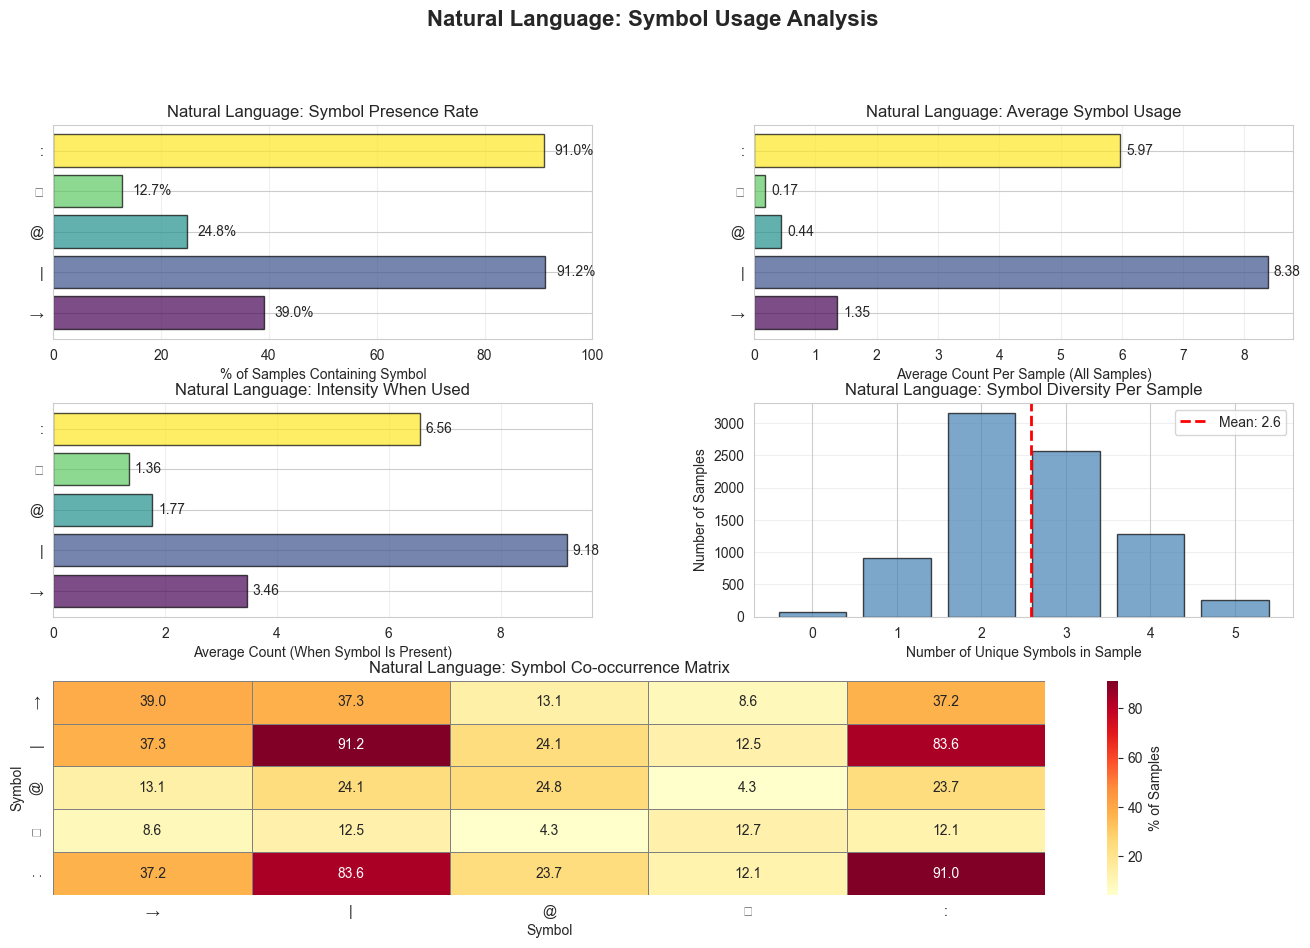


NATURAL LANGUAGE SYMBOL USAGE STATISTICS

Dataset Size: 8256 samples

SYMBOL PRESENCE RATES:
Symbol     Description               Samples    Rate      
------------------------------------------------------------
→          Arrow                     3223         39.0%
|          Pipe                      7532         91.2%
@          At                        2048         24.8%
∵          Because                   1052         12.7%
:          Colon                     7513         91.0%

AVERAGE COUNTS (ALL SAMPLES):
Symbol     Avg Count       Total Uses     
---------------------------------------------
→          1.35            11150          
|          8.38            69168          
@          0.44            3629           
∵          0.17            1429           
:          5.97            49313          

AVERAGE COUNTS (WHEN PRESENT):
Symbol     Avg When Used  
------------------------------
→          3.46           
|          9.18           
@          1.77           


In [ ]:
# Analysis #2: Symbol Usage Patterns
# Analyze how compression symbols are used (NL)


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 10)

# ============================================================================
# CONFIGURATION - CHANGE THIS FOR EACH RUN
# ============================================================================

DATASET_PATH = "../nl_v2.jsonl"  # OR "data/raw/code_dataset.jsonl"
DOMAIN_NAME = "Natural Language"  # OR "Code"
DOMAIN_TYPE = "nl"  # OR "code"

print(f"Analyzing: {DOMAIN_NAME}")
print(f"Dataset: {DATASET_PATH}")
print("=" * 80 + "\n")

# ============================================================================
# SYMBOL DEFINITIONS
# ============================================================================

# Your compression symbols
SYMBOLS = {
    "→": "Arrow (implies/leads to)",
    "|": "Pipe (separator/or)",
    "@": "At (location/decorator)",
    "∵": "Because (causation)",
    ":": "Colon (assignment/type)",
}

SYMBOL_CHARS = list(SYMBOLS.keys())

print("Tracking symbols:")
for sym, desc in SYMBOLS.items():
    print(f"  {sym} - {desc}")
print()

# ============================================================================
# 1. LOAD DATA
# ============================================================================


def load_dataset(filepath: str) -> list[dict]:
    """Load dataset with verbose/compressed pairs"""
    data = []
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data


data = load_dataset(DATASET_PATH)
print(f"✓ Loaded {len(data)} samples\n")

# ============================================================================
# 2. SYMBOL ANALYSIS FUNCTIONS
# ============================================================================


def count_symbols(text: str) -> dict:
    """Count occurrences of each symbol in text"""
    counts = {sym: text.count(sym) for sym in SYMBOL_CHARS}
    return counts


def analyze_sample(sample: dict) -> dict:
    """Analyze symbol usage in a single sample"""
    compressed = sample["compressed"]

    symbol_counts = count_symbols(compressed)

    return {
        "has_arrow": symbol_counts["→"] > 0,
        "has_pipe": symbol_counts["|"] > 0,
        "has_at": symbol_counts["@"] > 0,
        "has_because": symbol_counts["∵"] > 0,
        "has_colon": symbol_counts[":"] > 0,
        "count_arrow": symbol_counts["→"],
        "count_pipe": symbol_counts["|"],
        "count_at": symbol_counts["@"],
        "count_because": symbol_counts["∵"],
        "count_colon": symbol_counts[":"],
        "total_symbols": sum(symbol_counts.values()),
        "unique_symbols": sum(1 for v in symbol_counts.values() if v > 0),
        "compressed_length": len(compressed),
    }


# Analyze all samples
results = [analyze_sample(sample) for sample in data]
df = pd.DataFrame(results)

print(f"✓ Analyzed symbol usage in {len(df)} samples\n")

# ============================================================================
# 3. VISUALIZATION: SYMBOL FREQUENCY
# ============================================================================

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Calculate presence rates (% of samples containing each symbol)
presence_rates = {
    "→": df["has_arrow"].sum() / len(df) * 100,
    "|": df["has_pipe"].sum() / len(df) * 100,
    "@": df["has_at"].sum() / len(df) * 100,
    "∵": df["has_because"].sum() / len(df) * 100,
    ":": df["has_colon"].sum() / len(df) * 100,
}

# Average counts per sample (including samples without the symbol)
avg_counts = {
    "→": df["count_arrow"].mean(),
    "|": df["count_pipe"].mean(),
    "@": df["count_at"].mean(),
    "∵": df["count_because"].mean(),
    ":": df["count_colon"].mean(),
}

# Average counts per sample that HAS the symbol (conditional mean)
avg_counts_when_present = {
    "→": df[df["has_arrow"]]["count_arrow"].mean() if df["has_arrow"].sum() > 0 else 0,
    "|": df[df["has_pipe"]]["count_pipe"].mean() if df["has_pipe"].sum() > 0 else 0,
    "@": df[df["has_at"]]["count_at"].mean() if df["has_at"].sum() > 0 else 0,
    "∵": df[df["has_because"]]["count_because"].mean() if df["has_because"].sum() > 0 else 0,
    ":": df[df["has_colon"]]["count_colon"].mean() if df["has_colon"].sum() > 0 else 0,
}

# Plot 1: Symbol Presence Rate (% of samples)
ax1 = fig.add_subplot(gs[0, 0])
symbols = list(presence_rates.keys())
rates = list(presence_rates.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(symbols)))

bars = ax1.barh(symbols, rates, color=colors, alpha=0.7, edgecolor="black")
ax1.set_xlabel("% of Samples Containing Symbol")
ax1.set_title(f"{DOMAIN_NAME}: Symbol Presence Rate")
ax1.set_xlim(0, 100)

# Add value labels on bars
for i, (_bar, rate) in enumerate(zip(bars, rates, strict=True)):
    ax1.text(rate + 2, i, f"{rate:.1f}%", va="center", fontsize=10)


ax1.grid(True, alpha=0.3, axis="x")

# Plot 2: Average Count Per Sample
ax2 = fig.add_subplot(gs[0, 1])
counts = list(avg_counts.values())

bars = ax2.barh(symbols, counts, color=colors, alpha=0.7, edgecolor="black")
ax2.set_xlabel("Average Count Per Sample (All Samples)")
ax2.set_title(f"{DOMAIN_NAME}: Average Symbol Usage")

# Add value labels
for i, (_bar, count) in enumerate(zip(bars, counts, strict=True)):
    ax2.text(count + 0.1, i, f"{count:.2f}", va="center", fontsize=10)

ax2.grid(True, alpha=0.3, axis="x")

# Plot 3: Average Count When Present
ax3 = fig.add_subplot(gs[1, 0])
counts_present = list(avg_counts_when_present.values())

bars = ax3.barh(symbols, counts_present, color=colors, alpha=0.7, edgecolor="black")
ax3.set_xlabel("Average Count (When Symbol Is Present)")
ax3.set_title(f"{DOMAIN_NAME}: Intensity When Used")

# Add value labels
for i, (_bar, count) in enumerate(zip(bars, counts_present, strict=True)):
    ax3.text(count + 0.1, i, f"{count:.2f}", va="center", fontsize=10)

ax3.grid(True, alpha=0.3, axis="x")

# Plot 4: Distribution of unique symbols per sample
ax4 = fig.add_subplot(gs[1, 1])
unique_counts = df["unique_symbols"].value_counts().sort_index()

ax4.bar(unique_counts.index, unique_counts.values, color="steelblue", alpha=0.7, edgecolor="black")
ax4.set_xlabel("Number of Unique Symbols in Sample")
ax4.set_ylabel("Number of Samples")
ax4.set_title(f"{DOMAIN_NAME}: Symbol Diversity Per Sample")
ax4.grid(True, alpha=0.3, axis="y")

# Add mean line
mean_unique = df["unique_symbols"].mean()
ax4.axvline(mean_unique, color="red", linestyle="--", linewidth=2, label=f"Mean: {mean_unique:.1f}")
ax4.legend()

# Plot 5: Symbol co-occurrence heatmap
ax5 = fig.add_subplot(gs[2, :])

# Build co-occurrence matrix
cooccurrence = np.zeros((5, 5))
symbol_names = ["→", "|", "@", "∵", ":"]

for _, row in df.iterrows():
    present = [
        row["has_arrow"],
        row["has_pipe"],
        row["has_at"],
        row["has_because"],
        row["has_colon"],
    ]

    for i in range(5):
        for j in range(5):
            if present[i] and present[j]:
                cooccurrence[i, j] += 1

# Normalize by total samples
cooccurrence = cooccurrence / len(df) * 100

# Create heatmap
sns.heatmap(
    cooccurrence,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=symbol_names,
    yticklabels=symbol_names,
    cbar_kws={"label": "% of Samples"},
    ax=ax5,
    linewidths=0.5,
    linecolor="gray",
)
ax5.set_title(f"{DOMAIN_NAME}: Symbol Co-occurrence Matrix")
ax5.set_xlabel("Symbol")
ax5.set_ylabel("Symbol")

plt.suptitle(f"{DOMAIN_NAME}: Symbol Usage Analysis", fontsize=16, fontweight="bold", y=0.995)
plt.savefig(f"analysis_02_{DOMAIN_TYPE}_symbol_usage.png", dpi=300, bbox_inches="tight")
plt.show()

# ============================================================================
# 4. DETAILED STATISTICS
# ============================================================================

print("\n" + "=" * 80)
print(f"{DOMAIN_NAME.upper()} SYMBOL USAGE STATISTICS")
print("=" * 80)

print(f"\nDataset Size: {len(df)} samples")

print("\nSYMBOL PRESENCE RATES:")
print(f"{'Symbol':<10} {'Description':<25} {'Samples':<10} {'Rate':<10}")
print("-" * 60)
for sym in SYMBOL_CHARS:
    desc = SYMBOLS[sym].split("(")[0].strip()
    count = df[f"has_{['arrow', 'pipe', 'at', 'because', 'colon'][SYMBOL_CHARS.index(sym)]}"].sum()
    rate = count / len(df) * 100
    print(f"{sym:<10} {desc:<25} {count:<10} {rate:>6.1f}%")

print("\nAVERAGE COUNTS (ALL SAMPLES):")
print(f"{'Symbol':<10} {'Avg Count':<15} {'Total Uses':<15}")
print("-" * 45)
for sym in SYMBOL_CHARS:
    col = f"count_{['arrow', 'pipe', 'at', 'because', 'colon'][SYMBOL_CHARS.index(sym)]}"
    avg = df[col].mean()
    total = df[col].sum()
    print(f"{sym:<10} {avg:<15.2f} {total:<15.0f}")

print("\nAVERAGE COUNTS (WHEN PRESENT):")
print(f"{'Symbol':<10} {'Avg When Used':<15}")
print("-" * 30)
for sym, avg in avg_counts_when_present.items():
    print(f"{sym:<10} {avg:<15.2f}")

print("\nSYMBOL DIVERSITY:")
print(f"  Average unique symbols per sample: {df['unique_symbols'].mean():.2f}")
print(f"  Median unique symbols per sample:  {df['unique_symbols'].median():.0f}")
print(f"  Max unique symbols in one sample:  {df['unique_symbols'].max():.0f}")
print(
    f"  Samples using all 5 symbols:       {(df['unique_symbols'] == 5).sum()} ({(df['unique_symbols'] == 5).sum() / len(df) * 100:.1f}%)"
)
print(
    f"  Samples using 0 symbols:           {(df['unique_symbols'] == 0).sum()} ({(df['unique_symbols'] == 0).sum() / len(df) * 100:.1f}%)"
)

# ============================================================================
# 5. INSIGHTS & VALIDATION
# ============================================================================

print("\n" + "=" * 80)
print("INSIGHTS & VALIDATION")
print("=" * 80)

# Check for expected patterns based on domain
if DOMAIN_TYPE == "nl":
    print("\n📋 EXPECTED PATTERNS FOR NATURAL LANGUAGE:")
    print("  • @ symbol: Moderate usage (15-30%) for location contexts")
    print("  • ∵ symbol: Moderate-High usage (20-40%) for causation")
    print("  • → symbol: Moderate usage (20-40%) for implications")
    print("  • | symbol: Low-Moderate usage for separators")
    print("  • : symbol: High usage (60-90%) for definitions/assignments")

    print("\n📊 ACTUAL RESULTS:")
    at_rate = presence_rates["@"]
    because_rate = presence_rates["∵"]
    arrow_rate = presence_rates["→"]
    colon_rate = presence_rates[":"]

    # Validate expectations
    if at_rate < 10:
        print(f"  ⚠️  @ symbol underutilized ({at_rate:.1f}%) - expected 15-30%")
        print("     → ACTION: Review if location contexts are being compressed")
    elif at_rate > 30:
        print(f"  ⚠️  @ symbol overutilized ({at_rate:.1f}%) - may be used incorrectly")
    else:
        print(f"  ✅ @ symbol usage normal ({at_rate:.1f}%)")

    if because_rate < 15:
        print(f"  ⚠️  ∵ symbol underutilized ({because_rate:.1f}%) - expected 20-40%")
        print("     → ACTION: Review if causation contexts are being compressed")
    else:
        print(f"  ✅ ∵ symbol usage appropriate ({because_rate:.1f}%)")

    if colon_rate < 50:
        print(f"  ⚠️  : symbol underutilized ({colon_rate:.1f}%) - expected 60-90%")
    else:
        print(f"  ✅ : symbol usage strong ({colon_rate:.1f}%)")

else:  # code
    print("\n📋 EXPECTED PATTERNS FOR CODE:")
    print("  • @ symbol: High usage (70-95%) for decorators")
    print("  • : symbol: Very high usage (85-100%) for type hints/assignments")
    print("  • → symbol: Moderate-High usage (40-70%) for return indicators")
    print("  • | symbol: High usage (60-90%) for union types, pipes")
    print("  • ∵ symbol: Low usage (<10%) - rarely used in code")

    print("\n📊 ACTUAL RESULTS:")
    at_rate = presence_rates["@"]
    colon_rate = presence_rates[":"]
    arrow_rate = presence_rates["→"]
    pipe_rate = presence_rates["|"]
    because_rate = presence_rates["∵"]

    if at_rate < 60:
        print(f"  ⚠️  @ symbol underutilized ({at_rate:.1f}%) - expected 70-95%")
        print("     → ACTION: Decorators may not be preserved properly")
    else:
        print(f"  ✅ @ symbol usage strong ({at_rate:.1f}%)")

    if colon_rate < 80:
        print(f"  ⚠️  : symbol underutilized ({colon_rate:.1f}%) - expected 85-100%")
    else:
        print(f"  ✅ : symbol usage excellent ({colon_rate:.1f}%)")

    if because_rate > 10:
        print(f"  ⚠️  ∵ symbol unexpectedly high ({because_rate:.1f}%) - should be <10% in code")
        print("     → ACTION: May be misused, check samples")
    else:
        print(f"  ✅ ∵ symbol usage appropriate ({because_rate:.1f}%)")

# Symbol diversity check
zero_symbols = (df["unique_symbols"] == 0).sum()
if zero_symbols > 0:
    print("\n⚠️  SYMBOL COVERAGE ISSUE:")
    print(f"   {zero_symbols} samples ({zero_symbols / len(df) * 100:.1f}%) use NO symbols")
    print("   → ACTION: These samples may be poorly compressed")
    print("   → Investigate: Are they very short? Failed compression?")

# High symbol usage
high_symbol_samples = df[df["total_symbols"] > df["total_symbols"].quantile(0.95)]
if len(high_symbol_samples) > 0:
    print("\n📊 HIGH SYMBOL USAGE:")
    print(f"   Top 5% of samples use {high_symbol_samples['total_symbols'].min():.0f}+ symbols")
    print(f"   Max symbols in one sample: {df['total_symbols'].max():.0f}")

# ============================================================================
# 6. CO-OCCURRENCE INSIGHTS
# ============================================================================

print("\n" + "=" * 80)
print("SYMBOL CO-OCCURRENCE INSIGHTS")
print("=" * 80)

print("\nMost common symbol pairs (co-occur in same sample):")
cooccur_pairs = []
for i in range(len(symbol_names)):
    for j in range(i + 1, len(symbol_names)):
        if cooccurrence[i, j] > 0:
            cooccur_pairs.append((symbol_names[i], symbol_names[j], cooccurrence[i, j]))

cooccur_pairs.sort(key=lambda x: x[2], reverse=True)
for sym1, sym2, rate in cooccur_pairs[:5]:
    print(f"  {sym1} + {sym2}: {rate:.1f}% of samples")

# ============================================================================
# 7. NEXT STEPS
# ============================================================================

print("\n" + "=" * 80)
print("NEXT STEPS")
print("=" * 80)

if DOMAIN_TYPE == "nl":
    print("1. ✅ NL symbol analysis complete")
    print("2. ⏭️  Change to 'code_dataset.jsonl' and re-run")
    print("3. ⏭️  Compare NL vs Code symbol usage patterns")
    print("4. ⏭️  Move to Analysis #3: Token Length Distribution")
else:
    print("1. ✅ Code symbol analysis complete")
    print("2. 📊 Compare with NL results:")
    print("   • Is @ high in code (decorators) and low in NL?")
    print("   • Is ∵ high in NL (causation) and low in code?")
    print("   • Are patterns as expected?")
    print("3. ⏭️  Move to Analysis #3: Token Length Distribution")

print("=" * 80)

In [10]:
from typing import Any

# ===== PARAMETERS =====
INPUT_PATH = Path("../nl_v2.jsonl")
OUT_DIR = Path("../splits")

THRESHOLD = 0.20  # 20% reduction
MIN_LEN = 1       # skip empty samples


def safe_strip_len(x: Any) -> int:
    if not isinstance(x, str):
        return 0
    return len(x.strip())


def split_by_compression(
    input_path: Path,
    out_dir: Path,
    threshold: float,
    min_len: int,
) -> None:
    if not input_path.exists():
        raise FileNotFoundError(f"Input file not found: {input_path}")

    out_dir.mkdir(parents=True, exist_ok=True)

    bad_path = out_dir / "bad_or_undercompressed.jsonl"
    good_path = out_dir / "good_20pct_or_more.jsonl"
    skipped_path = out_dir / "skipped_invalid.jsonl"

    n_total = n_bad = n_good = n_skipped = 0

    with (
        input_path.open("r", encoding="utf-8") as f_in,
        bad_path.open("w", encoding="utf-8") as f_bad,
        good_path.open("w", encoding="utf-8") as f_good,
        skipped_path.open("w", encoding="utf-8") as f_skip,
    ):
        for line_no, line in enumerate(f_in, start=1):
            line = line.strip()
            if not line:
                continue

            n_total += 1

            try:
                obj: dict[str, Any] = json.loads(line)
            except json.JSONDecodeError:
                f_skip.write(
                    json.dumps({"line_no": line_no, "reason": "json_decode_error"}, ensure_ascii=False)
                    + "\n"
                )
                n_skipped += 1
                continue

            verbose = obj.get("verbose", "")
            compressed = obj.get("compressed", "")

            if not isinstance(verbose, str) or not isinstance(compressed, str):
                f_skip.write(
                    json.dumps(
                        {"line_no": line_no, "reason": "non_string_fields", "keys": list(obj.keys())},
                        ensure_ascii=False,
                    )
                    + "\n"
                )
                n_skipped += 1
                continue

            v_len = safe_strip_len(verbose)
            c_len = safe_strip_len(compressed)

            if v_len < min_len or c_len < min_len:
                f_skip.write(
                    json.dumps(
                        {"line_no": line_no, "reason": "too_short", "v_len": v_len, "c_len": c_len},
                        ensure_ascii=False,
                    )
                    + "\n"
                )
                n_skipped += 1
                continue

            ratio = c_len / v_len
            reduction = 1.0 - ratio

            obj["_metrics"] = {
                "char_verbose": v_len,
                "char_compressed": c_len,
                "ratio_c_over_v": round(ratio, 4),
                "reduction": round(reduction, 4),
                "threshold": threshold,
            }

            if ratio > 1.0 or reduction < threshold:
                f_bad.write(json.dumps(obj, ensure_ascii=False) + "\n")
                n_bad += 1
            else:
                f_good.write(json.dumps(obj, ensure_ascii=False) + "\n")
                n_good += 1

    print("✅ Split complete")
    print(f"Input file: {input_path}")
    print(f"Output dir: {out_dir}")
    print(f"Total samples: {n_total}")
    print(f"GOOD (>= {threshold:.0%} reduction): {n_good}")
    print(f"BAD  (<  {threshold:.0%} or elongated): {n_bad}")
    print(f"Skipped (invalid): {n_skipped}")


# Run
split_by_compression(INPUT_PATH, OUT_DIR, THRESHOLD, MIN_LEN)


✅ Split complete
Input file: ../nl_v2.jsonl
Output dir: ../splits
Total samples: 8256
GOOD (>= 20% reduction): 5326
BAD  (<  20% or elongated): 2930
Skipped (invalid): 0


# Summary :
Verbose samples are sometimes expanded, and the distribution suggests that almost half of our samples are expanded or less than 20% compression. Hence, a very slight chance that the model has learnt to use symbols instead.